# Data Prep

The goal of this notebook is to prep the data for the alignment task.  This includes computing audio features and generating a query list.

In [1]:
import numpy as np
import librosa as lb
import os
import os.path
from pathlib import Path
import multiprocessing
import glob

In [2]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
AUDIO_ROOT = Path('Chopin_Mazurkas/wav_22050_mono')
FEATURES_ROOT = Path('features')
train_files = Path('cfg_files/filelist.train.txt')
test_files = Path('cfg_files/filelist.test.txt')

In [3]:
if not os.path.exists(FEATURES_ROOT):
    os.mkdir(FEATURES_ROOT)

## Create filelists text files

In [4]:
import random
from itertools import combinations

In [5]:
def get_combinations(piece, filelist, seed=42):
    """
    For a given piece (ie. Chopin_Op017No4), return a list
    of tuples of all pair wise combinations between performances.
    """
    performances = []
    with open(filelist, 'r') as infile:
        for performance in infile:
            if piece in performance:
                performances.append(performance.split())
    pairs = list(combinations(performances, 2))
    random.seed(seed)
    random.shuffle(pairs)
    return pairs

In [6]:
train_pairs = get_combinations('Chopin_Op017No4', train_files) + get_combinations('Chopin_Op063No3', train_files)
test_pairs = get_combinations('Chopin_Op024No2', test_files) + get_combinations('Chopin_Op030No2', test_files) + get_combinations('Chopin_Op068No3', test_files)

In [7]:
def create_file_list(pairs, outdir, limit=None):
    """ Save pairs to filelist.*.txt file """
    if limit:
        pairs = pairs[:limit]
    with open(outdir, 'w') as outfile:
        for a, b in pairs:
            outfile.write(f"{a[0]} {b[0]}\n")

In [8]:
# train-toy: randomly select 5 pairs from Op 17 #4
create_file_list(train_pairs, 'cfg_files/filelist.train_toy.txt', 5)
# train-small: randomly select 200 pairs from Op 17 #4
create_file_list(train_pairs, 'cfg_files/filelist.train_small.txt', 200)
# train-medium: includes all (63 choose 2) pairs for Op 17 #4
create_file_list(train_pairs, 'cfg_files/filelist.train_medium.txt', 1953)
# train-full: includes all (63 choose 2) + (88, choose 2) pairs for Op 17 #4 and Op 63 #3
create_file_list(train_pairs, 'cfg_files/filelist.train_full.txt')
# test-full: includes all pairs from the 3 test Mazurkas
create_file_list(test_pairs, 'cfg_files/filelist.test_full.txt')

## Delete exceptional pieces

In [20]:
os.remove("./Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Ginzburg-1957_pid9156-10.wav")
os.remove("./Chopin_Mazurkas/wav_22050_mono/Chopin_Op068No3/Chopin_Op068No3_Koczalski-1948_pid9140-05.wav")

## Find median duration for each piece

In [21]:
def get_median():
    medians = {}
    dirs = glob.glob('Chopin_Mazurkas/wav_22050_mono/*/**/', recursive=True)
    for dir in dirs:
        piece = os.path.split(os.path.normpath(dir))[-1]
        performances = glob.glob(f'{dir}*.wav', recursive=True)
        durations = [lb.get_duration(filename=path) for path in performances]
        durations.sort()
        medians[piece] = durations[len(durations)//2]
    return medians

In [22]:
medians = get_median()
medians

{'Chopin_Op063No3': 128.22149659863945,
 'Chopin_Op017No4': 254.92816326530613,
 'Chopin_Op030No2': 87.30149659863946,
 'Chopin_Op024No2': 136.6748299319728,
 'Chopin_Op068No3': 99.64816326530612}

## Construct modified benchmark datasets

#### Create separate directories for each dataset

In [12]:
def create_mazurka_directories(time_modify):
    '''create separate directories for each time scale modification'''
    for item in time_modify:
        dir = 'Mazurkas_median_x{}'.format(item)
        ann_dir = '{}/annotations_beat'.format(dir)
        wav_dir = '{}/wav_22050_mono'.format(dir)
        for mazurka in ['Chopin_Op017No4','Chopin_Op024No2','Chopin_Op030No2','Chopin_Op063No3','Chopin_Op068No3']:
            ann_piece_dir = '{}/{}'.format(ann_dir, mazurka)
            wav_piece_dir = '{}/{}'.format(wav_dir, mazurka)
            if not os.path.exists(ann_piece_dir):
                os.makedirs(ann_piece_dir)
            if not os.path.exists(wav_piece_dir):
                os.makedirs(wav_piece_dir)

In [13]:
factors = ['1.000','0.500','0.630','0.794','1.260','1.588','2.000']
create_mazurka_directories(factors)

## Perform time-scale modification

##### Generate .wav files

In [23]:
import soundfile as sf
import IPython.display as ipd
from tsm_tools import *
import pandas as pd

In [24]:
def time_scale_batch(filelist, piece, median_duration, factor, outdir, n_cores):
    '''time-scale modify for all .wav files for one mazurka for one factor'''
    inputs = []
    with open(filelist, 'r') as cfg_file:
        for line in cfg_file:
            if piece in line:
                # make path to .wav file
                path_to_wav = 'Chopin_Mazurkas/wav_22050_mono/{}.wav'.format(line[:-1])
                inputs.append((path_to_wav, median_duration, factor, outdir))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(time_scale_single, inputs)
    return

In [26]:
def time_scale_single(path_to_wav, median_duration, factor, outdir):
    '''time-scale modify for one .wav file'''
    y, sr = lb.load(path_to_wav)
    # do time scale modification
    old_duration = lb.get_duration(y=y, sr=sr)
    ratio = (median_duration*factor) / old_duration
    y_mod = tsm_hybrid(y, alpha=ratio)
    # save to new .wav file
    new_path_to_wav = '{}{}'.format(outdir, path_to_wav[15:]) # e.g. 'Mazurkas_median_x1.000/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Kitain-1937_pid9163-02.wav'
    #lb.output.write_wav(new_path_to_wav, y, sr)
    sf.write(new_path_to_wav, y_mod, sr)
    return

In [27]:
def time_scale_by_mazurka(filelist, piece, median_duration, factors):
    '''time-scale modify by all factors with one mazurka'''
    for factor in factors:
        time_scale_batch(filelist, piece, median_duration, float(factor),'Mazurkas_median_x{}'.format(factor), 24)
        print("Done with Mazurkas_median_x{}/{}".format(factor, piece))
    return

In [28]:
time_scale_by_mazurka(train_files, 'Chopin_Op017No4', medians["Chopin_Op017No4"], factors)
time_scale_by_mazurka(train_files, 'Chopin_Op063No3', medians["Chopin_Op063No3"], factors)
time_scale_by_mazurka(test_files, 'Chopin_Op024No2', medians["Chopin_Op024No2"], factors)
time_scale_by_mazurka(test_files, 'Chopin_Op030No2', medians["Chopin_Op030No2"], factors)
time_scale_by_mazurka(test_files, 'Chopin_Op068No3', medians["Chopin_Op068No3"], factors)

Done with Mazurkas_median_x1.000/Chopin_Op017No4
Done with Mazurkas_median_x0.500/Chopin_Op017No4
Done with Mazurkas_median_x0.630/Chopin_Op017No4
Done with Mazurkas_median_x0.794/Chopin_Op017No4
Done with Mazurkas_median_x1.260/Chopin_Op017No4
Done with Mazurkas_median_x1.588/Chopin_Op017No4
Done with Mazurkas_median_x2.000/Chopin_Op017No4
Done with Mazurkas_median_x1.000/Chopin_Op063No3
Done with Mazurkas_median_x0.500/Chopin_Op063No3
Done with Mazurkas_median_x0.630/Chopin_Op063No3
Done with Mazurkas_median_x0.794/Chopin_Op063No3
Done with Mazurkas_median_x1.260/Chopin_Op063No3
Done with Mazurkas_median_x1.588/Chopin_Op063No3
Done with Mazurkas_median_x2.000/Chopin_Op063No3
Done with Mazurkas_median_x1.000/Chopin_Op024No2
Done with Mazurkas_median_x0.500/Chopin_Op024No2
Done with Mazurkas_median_x0.630/Chopin_Op024No2
Done with Mazurkas_median_x0.794/Chopin_Op024No2
Done with Mazurkas_median_x1.260/Chopin_Op024No2
Done with Mazurkas_median_x1.588/Chopin_Op024No2
Done with Mazurkas_m

##### Generate .beat files

In [29]:
import pandas as pd

In [30]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [31]:
def create_beat_annotation(in_path_beat, in_path_wav, out_path, num_multiply): # num_multiply should be median*factor
    '''modifies beat annotations for one .wav file'''
    # load .wav file to get original duration
    real_duration = lb.get_duration(filename=in_path_wav)
    # (median*factor)/real_dur
    original_ts = getTimestamps(in_path_beat)
    modified_ts = (original_ts*num_multiply)/real_duration
    index = 0
    curr_read = 0
    new_lines = []
    with open(in_path_beat, 'r') as infile:
        for line in infile:
            if curr_read < 3: # copy first 3 lines
                new_lines.append(line)
                curr_read += 1
                continue
            else: # modify the rest of the lines
                label = line.split('\t')[-1]
                if index+1 == len(modified_ts):
                    curr_start, curr_end = modified_ts[index], 0.0
                else:
                    curr_start, curr_end = modified_ts[index], modified_ts[index+1]
                new_string = '{}\t{}\t{}'.format(curr_start, curr_end, label)
                new_lines.append(new_string)
                index += 1
    with open(out_path, 'w') as outfile:
        for line in new_lines:
            outfile.write(line)
    return new_lines

In [ ]:
# create_beat_annotation('Chopin_Mazurkas/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.beat', 'Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav', 'test.beat', Chopin_Op017No4_MEDIAN*2)[3:8]

In [32]:
def create_beat_annotation_batch(filelist, piece, median_duration, factor, outdir, n_cores): # e.g. outdir is 'Mazurkas_median_x2.000/annotations_beat/Chopin_Op017No4'
    '''modifies beat annotations for all .wav files for one Mazurka for one factor'''
    inputs = []
    with open(filelist, 'r') as cfg_file:
        for line in cfg_file:
            if piece in line:
                path_to_beat = 'Chopin_Mazurkas/annotations_beat/{}.beat'.format(line[:-1])
                path_to_wav = 'Chopin_Mazurkas/wav_22050_mono/{}.wav'.format(line[:-1])
                out_path = 'Mazurkas_median_x{}/annotations_beat/{}.beat'.format(factor, line[:-1])
                num_multiply = median_duration*float(factor)
                inputs.append((path_to_beat, path_to_wav, out_path, num_multiply))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(create_beat_annotation, inputs)
    return

In [ ]:
# create_beat_annotation_batch(train_files, 'Chopin_Op017No4', Chopin_Op017No4_MEDIAN, '2.000', 'Mazurkas_median_x2.000/annotations_beat/Chopin_Op017No4', 24)

In [33]:
def beat_annotation_by_mazurka(filelist, piece, median_duration, factors):
    '''modifies beat annotations by all factors with one mazurka'''
    for factor in factors:
        create_beat_annotation_batch(filelist, piece, median_duration, factor, 'Mazurkas_median_x{}/annotations_beat/{}'.format(factor, piece), 24)
        print("Done with Mazurkas_median_x{}/annotations_beat/{}".format(factor, piece))
    return

In [34]:
beat_annotation_by_mazurka(train_files, 'Chopin_Op017No4', medians["Chopin_Op017No4"], factors)
beat_annotation_by_mazurka(train_files, 'Chopin_Op063No3', medians["Chopin_Op063No3"], factors)
beat_annotation_by_mazurka(test_files, 'Chopin_Op024No2', medians["Chopin_Op024No2"], factors)
beat_annotation_by_mazurka(test_files, 'Chopin_Op030No2', medians["Chopin_Op030No2"], factors)
beat_annotation_by_mazurka(test_files, 'Chopin_Op068No3', medians["Chopin_Op068No3"], factors)

Done with Mazurkas_median_x1.000/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x0.500/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x0.630/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x0.794/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x1.260/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x1.588/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x2.000/annotations_beat/Chopin_Op017No4
Done with Mazurkas_median_x1.000/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x0.500/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x0.630/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x0.794/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x1.260/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x1.588/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x2.000/annotations_beat/Chopin_Op063No3
Done with Mazurkas_median_x1.000/annotations_beat/Chopin_Op024No2
Done with 

### Compute features on clean audio

First we compute features on the audio.

##### Compute features on the 'Chopin_Mazurkas' directory

In [41]:
def compute_chroma_single(infile, outfile, sr = 22050, hop_length=512):
    y, sr = lb.core.load(infile, sr = sr)
    #F = lb.feature.chroma_cens(y, sr=sr, hop_length=hop_length)
    F = lb.feature.chroma_cqt(y, sr=sr, hop_length=hop_length, norm=2)
    np.save(outfile, F)
    return

In [42]:
def compute_chroma_batch(filelist, outdir, n_cores):
    # prep inputs for parallelization
    inputs = []
    with open(filelist, 'r') as f:
        for line in f:
            relpath = line.strip()
            reldir, fileid = os.path.split(relpath)
            featdir = outdir / reldir
            featdir.mkdir(parents=True, exist_ok=True)
            featfile = (featdir / fileid).with_suffix('.npy')
            audiofile = (AUDIO_ROOT / relpath).with_suffix('.wav')
            if os.path.exists(featfile):
                print(f"Skipping {featfile}")
            else:
                inputs.append((audiofile, featfile))
    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(compute_chroma_single, inputs)
    return

In [43]:
FEATS_CLEAN_DIR = FEATURES_ROOT / 'clean'
compute_chroma_batch(train_files, FEATS_CLEAN_DIR, 24)
compute_chroma_batch(test_files, FEATS_CLEAN_DIR, 24)

##### Compute features on the modified median directories e.g. 'Mazurkas_median_x0.500'

In [44]:
def compute_chroma_median(filelist, median_dir, outdir, n_cores): # outdir should be 'features/clean'
    '''compute features for each median directory e.g. for all .wav files in 'Mazurkas_median_x0.500' '''
    
    # prep inputs for parallelization
    inputs = []
    with open(filelist, 'r') as f:
        for line in f:
            relpath = line.strip()
            reldir, fileid = os.path.split(relpath)
            featdir = median_dir / outdir / reldir
            featdir.mkdir(parents=True, exist_ok=True)
            featfile = (featdir / fileid).with_suffix('.npy')
            audiofile = (median_dir / Path('wav_22050_mono') / relpath).with_suffix('.wav')
            if os.path.exists(featfile):
                print(f"Skipping {featfile}")
            else:
                inputs.append((audiofile, featfile))

    # process files in parallel
    pool = multiprocessing.Pool(processes = n_cores)
    pool.starmap(compute_chroma_single, inputs)
    return

In [45]:
FEATS_CLEAN_DIR = FEATURES_ROOT / 'clean'
median_directories = ['Mazurkas_median_x0.500', 'Mazurkas_median_x0.630', 'Mazurkas_median_x0.794', 'Mazurkas_median_x1.000', 'Mazurkas_median_x1.260', 'Mazurkas_median_x1.588', 'Mazurkas_median_x2.000']

In [46]:
# compute chromas for each directory
for median_dir in median_directories:
    compute_chroma_median(train_files, median_dir, FEATS_CLEAN_DIR, 24)
    compute_chroma_median(test_files, median_dir, FEATS_CLEAN_DIR, 24)
    print("Finished generating features for {}".format(median_dir))

Finished generating features for Mazurkas_median_x0.500
Finished generating features for Mazurkas_median_x0.630
Finished generating features for Mazurkas_median_x0.794
Finished generating features for Mazurkas_median_x1.000
Finished generating features for Mazurkas_median_x1.260
Finished generating features for Mazurkas_median_x1.588
Finished generating features for Mazurkas_median_x2.000


## Verification

Ensure all audio durations are within 10 milliseconds of their intended duration.

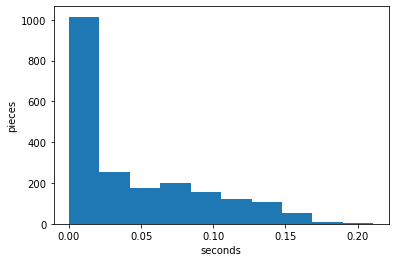

In [71]:
import matplotlib.pyplot as plt

def verify_benchmark_durations(medians, tolerance = 1e-2):
    dirs = glob.glob('Mazurkas_median_*')
    deviations = []
    for dir in dirs:
        pieces = glob.glob(f'{dir}/wav_22050_mono/*/**/', recursive=True)
        for piece in pieces:
            factor, pieceid = os.path.split(os.path.normpath(piece))
            factor = float(os.path.split(factor)[0].split('_x')[1])
            recordings = glob.glob(f"{piece}/*")
            for recording in recordings:
                duration = lb.get_duration(filename=recording)
                deviation = abs(duration - (medians[pieceid] * factor))
                deviations.append(deviation)
    return deviations
deviations = verify_benchmark_durations(medians)
plt.hist(deviations)
plt.xlabel("seconds")
plt.ylabel("pieces")
plt.show()

Verify .beat files by examining example piece Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav x2.000.

In [68]:
create_beat_annotation('Chopin_Mazurkas/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.beat', 'Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav', 'test.beat', medians["Chopin_Op017No4"]*2)[3:13]

['3.7878267363045808\t5.3110904403952945\t2\n',
 '5.3110904403952945\t6.407840307340608\t3\n',
 '6.407840307340608\t7.3217985297950365\t1\n',
 '7.3217985297950365\t8.174826204085836\t2\n',
 '8.174826204085836\t9.048164061097845\t3\n',
 '9.048164061097845\t10.043363014437112\t1\n',
 '10.043363014437112\t11.302594343152101\t2\n',
 '11.302594343152101\t13.435163528879098\t3\n',
 '13.435163528879098\t14.445099550800874\t1\n',
 '14.445099550800874\t17.77875607414859\t2\n']

In [69]:
real_duration = lb.get_duration(filename="Chopin_Mazurkas/wav_22050_mono/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.wav")
factor = medians["Chopin_Op017No4"] * 2 / real_duration
curr_read = 0
lines = []
with open('Chopin_Mazurkas/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Weissenberg-1971_pid9052b-09.beat', 'r') as infile:
    for line in infile:
        if curr_read < 3:
            curr_read += 1
            continue
        start, end, label = line.split('\t')
        start = factor * float(start)
        end = factor * float(end)
        lines.append(f"{start}\t{end}\t{label}")
        curr_read += 1
        if curr_read >= 13:
            break
lines

['3.787826736304581\t5.3110904403952945\t2\n',
 '5.3110904403952945\t6.407840307340609\t3\n',
 '6.407840307340609\t7.321798529795037\t1\n',
 '7.321798529795037\t8.174826204085836\t2\n',
 '8.174826204085836\t9.048164061097847\t3\n',
 '9.048164061097847\t10.04336301443711\t1\n',
 '10.04336301443711\t11.302594343152101\t2\n',
 '11.302594343152101\t13.4351635288791\t3\n',
 '13.4351635288791\t14.445099550800876\t1\n',
 '14.445099550800876\t17.77875607414859\t2\n']